In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as  transforms
from torchvision import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from keras.preprocessing import image

In [3]:
transform = transforms.Compose([
                      transforms.Grayscale(num_output_channels=1),
                      transforms.RandomHorizontalFlip(),
                      transforms.Resize((28,28)),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,),(0.5,))
                      ])

In [4]:
# Path to the dataset (update the path as needed)
data_dir = "C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset"

# Load the dataset with transformations
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Paths to the pre-split datasets (update the paths as needed)
train_dir = "C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset/Training"
test_dir = "C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset/Testing"


# Load the pre-split datasets with transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))
print("Image size:", images.shape) 


Image size: torch.Size([32, 1, 28, 28])


In [5]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.fc1 = nn.Linear(28*28,128)
    self.fc2 = nn.Linear(128,4)
    self.relu=nn.ReLU()

  def forward(self,x):
    x = x.view(-1,28*28)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [6]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer =optim.Adam(model.parameters(),lr=0.001)

In [9]:
epochs = 5
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct =0
  total =0
  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs ,labels )
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _,predicted = torch.max(outputs,1)
    total +=labels.size(0)
    correct +=(predicted ==labels).sum().item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)} , Accuracy: {100*correct/total}")

Epoch 1/5, Loss: 0.9218429117229398 , Accuracy: 63.1827731092437
Epoch 2/5, Loss: 0.7220138068305714 , Accuracy: 71.97128851540616
Epoch 3/5, Loss: 0.6604337137837649 , Accuracy: 74.68487394957984
Epoch 4/5, Loss: 0.6178745038016549 , Accuracy: 75.99789915966386
Epoch 5/5, Loss: 0.5765024138895493 , Accuracy: 78.22128851540616


In [7]:
#  Evaluate on Test Data
model.eval()
correct =0
total =0
act_labels =torch.tensor([])
model_predicted =torch.tensor([])

with torch.no_grad():
  for inputs, labels in test_loader:
    outputs =model(inputs)
    act_labels = torch.cat((act_labels ,labels ) ,dim =0)
    _, predicted = torch.max(outputs,1)
    model_predicted = torch.cat((model_predicted ,predicted),dim=0 )
    total +=labels.size(0)
    correct += (predicted ==labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}")

print(model_predicted)
print(act_labels)

Test Accuracy: 21.51
tensor([1., 1., 0.,  ..., 2., 2., 0.])
tensor([0., 0., 0.,  ..., 3., 3., 3.])


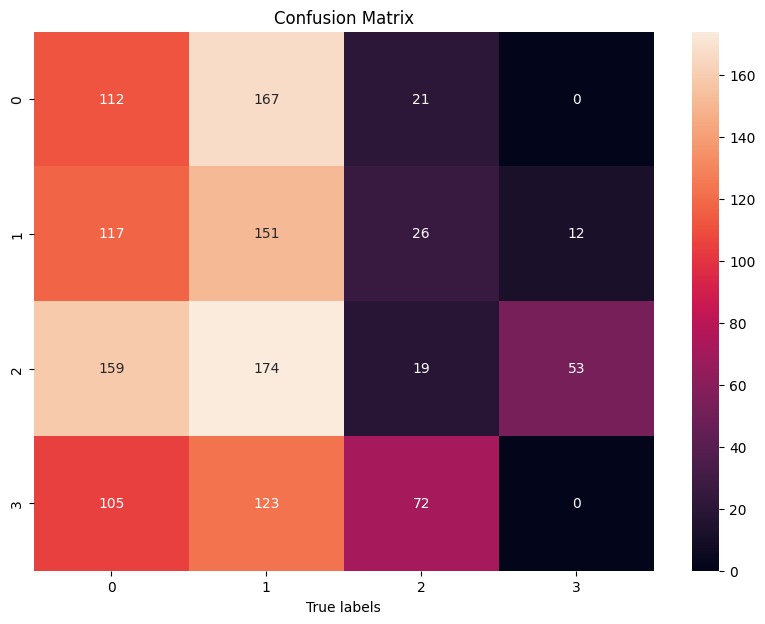

In [9]:
confusionmatrix = confusion_matrix(act_labels ,model_predicted )

plt.figure(figsize =(10,7))
sns.heatmap(confusionmatrix,annot=True ,fmt ='g' ,xticklabels=np.arange(4) ,yticklabels=np.arange(4))

plt.title("Confusion Matrix")
plt.xlabel("Predicted, labels")
plt.xlabel("True labels")
plt.show()

In [10]:
def calculate_metrics(confusionmatrix):
    precision = []
    recall = []
    f1_score = []

    for i in range(len(confusionmatrix)):
        tp = confusionmatrix[i, i]  # True Positives
        fp = sum(confusionmatrix[:, i]) - tp  # False Positives
        fn = sum(confusionmatrix[i, :]) - tp  # False Negatives

        if tp + fp == 0:
            precision.append(0)
        else:
            precision.append(tp / (tp + fp))

        if tp + fn == 0:
            recall.append(0)
        else:
            recall.append(tp / (tp + fn))

        if precision[-1] + recall[-1] == 0:
            f1_score.append(0)
        else:
            f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))

    return precision, recall, f1_score



def print_metrics_per_class(precision, recall, f1_score):
    print("Class-wise Metrics:")
    print(f"{'Class':<6} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    for i in range(len(precision)):
        print(f"{i:<6} {precision[i]:<10.3f} {recall[i]:<10.3f} {f1_score[i]:<10.3f}")

precision, recall, f1_score = calculate_metrics(confusionmatrix)
print_metrics_per_class(precision, recall, f1_score)


Class-wise Metrics:
Class  Precision  Recall     F1 Score  
0      0.227      0.373      0.282     
1      0.246      0.493      0.328     
2      0.138      0.047      0.070     
3      0.000      0.000      0.000     


In [14]:
def classify_image(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    # Print for debugging
    print(f"Predicted index: {predicted.item()}")
    print(f"Model output: {outputs}")
    print(f"Class Names: {class_names}")
    
    # Ensure predicted index is within range
    if predicted.item() < len(class_names):
        print(f"Predicted Class: {class_names[predicted.item()]}")
    else:
        print("Prediction out of range!")

# Path to the test image (update with an actual image path)
test_image_path = "C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset/Testing/pituitary/Te-pi_0017.jpg"
img = Image.open(test_image_path)
plt.imshow(img)

# Example: Define class names if necessary
class_names = ['class_0', 'class_1', 'class_2', 'class_3']  # Replace with actual class names
classify_image(test_image_path, model, transform, class_names)


NameError: name 'Image' is not defined

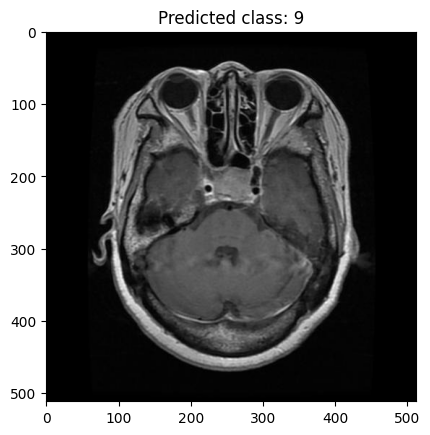

In [121]:

from PIL import Image
def test_single_img(img_path ,model):
  img = Image.open(img_path)
  img  = transform(img).unsqueeze(0)
  model.eval()

  with torch.no_grad():
    outputs = model(img)
    _,predicted = torch.max(outputs,1)
  return predicted.item()

img_path = "C:/Swetha/ASEB/Infosys_internship/brain_tumor_dataset/Testing/pituitary/Te-pi_0017.jpg"

predicted_class = test_single_img(img_path,model)

img = Image.open(img_path)
plt.imshow(img, cmap ="gray")
plt.title(f"Predicted class: {predicted_class}")
plt.show()